<h1><u>PyHEP 2020: <i>Columnar Analysis at Scale with Coffea</i></u></h1>
<h2>Authors</h2>
<b>Presenter:</b> Mat Adamec (<i>UNL</i>)
<br/>
<br/>
<b>coffea:</b>
<br/>
<a href="https://doi.org/10.5281/zenodo.3899563"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.3899563.svg" alt="DOI" align="left"></a>
<br/>
    <ul>
        <li>Lindsey Gray, Matteo Cremonesi, Bo Jayatilaka, Oliver Gutsche, Nick Smith, Allison Hall, Kevin Pedro, Maria Acosta <i>(FNAL)</i>; Andrew Melo <i>(Vanderbilt)</i>; Stefano Belforte <i>(INFN)</i>; and others</li>
        <li>In collaboration with IRIS-HEP members: Jim Pivarski <i>(Princeton)</i>, Ben Galewsky <i>(NCSA)</i>, Mark Neubauer <i>(UIUC)</i></li>
        <br/>
    </ul>
<b>coffea-casa:</b>
    <ul>
        <li>Ken Bloom, Oksana Shadura <i>(UNL)</i>; Garhan Attebury, Carl Lundstedt, Derek Wietzel <i>(UNL-HCC)</i>; Mátyás Selmeci <i>(UWM)</i>; Brian Bockelman <i>(Morgridge Institute)</i></li>
    </ul>
<hr />
<h2>Introduction</h2>
<p>This tutorial is intended to be a walkthrough of the foundations of an analysis implemented in Coffea (specifically, single top-Higgs production, <a href="https://doi.org/10.1103/PhysRevD.99.092005">https://doi.org/10.1103/PhysRevD.99.092005</a>). We will go through data selection using a columnar representation, go over some edge cases to that representation, and plot some relevant data. At the end, we will wrap everything together and demonstrate how Coffea can be easily deployed for scaling an analysis up. This is also a prime opportunity to show off a prototype analysis facility being developed by the coffea-casa team, which was presented yesterday by Oksana Shadura ("<a href="https://indico.cern.ch/event/882824/timetable/#43-a-prototype-us-cms-analysis">A prototype U.S. CMS analysis facility</a>").</p>


<h2>Review</h2>
<p>For the purposes of this tutorial, we will load in a sample file used in the analysis, as well as NanoEvents from the Coffea package. A <a href="https://indico.cern.ch/event/882824/timetable/#30-the-nanoevents-object">NanoEvents tutorial</a> was given on Monday by Nick Smith, but I will give a quick review of its basics.</p>

In [1]:
try:
    import numpy as np
except ImportError as e:
    !pip install numpy
    import numpy as np

try:
    from coffea.nanoaod import NanoEvents
except ImportError as e:
    !conda install -c conda-forge xrootd --yes
    !pip install coffea
    from coffea.nanoaod import NanoEvents
    
try:
    import numba as nb
except ImportError as e:
    !pip install numba
    import numba as nb

import time

file = "root://xrootd.unl.edu//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root"
events = NanoEvents.from_file(file, entrystop=100000)

<p>NanoEvents lazily reads <code>file</code> into a jagged array structure (specifically, an <a href="https://github.com/scikit-hep/awkward-array">awkward array</a>), <code>events</code>. We can poke around <code>events</code> by looking at the <code>.columns</code> attribute, which tells us all of the possible fields we can access.</p>

In [2]:
print(events)
print('\n')
print(events.columns)

[<event 0> <event 1> <event 2> ... <event 99997> <event 99998> <event 99999>]


['fixedGridRhoFastjetCentralChargedPileUp', 'LHEScaleWeight', 'ChsMET', 'genTtbarId', 'SV', 'Generator', 'LHEPart', 'GenDressedLepton', 'run', 'L1PreFiringWeight', 'SoftActivityJetNjets2', 'Photon', 'Electron', 'OtherPV', 'L1', 'genWeight', 'PSWeight', 'fixedGridRhoFastjetCentralNeutral', 'Tau', 'GenMET', 'LHE', 'RawMET', 'MET', 'SoftActivityJetHT5', 'SoftActivityJetHT2', 'FatJet', 'SoftActivityJetHT10', 'IsoTrack', 'Muon', 'Jet', 'SoftActivityJetHT', 'luminosityBlock', 'Pileup', 'GenPart', 'fixedGridRhoFastjetCentral', 'CorrT1METJet', 'GenJetAK8', 'GenVisTau', 'LHEReweightingWeight', 'SoftActivityJetNjets10', 'HLTriggerFinalPath', 'SubJet', 'TkMET', 'Flag', 'PuppiMET', 'LHEPdfWeight', 'SubGenJetAK8', 'GenJet', 'fixedGridRhoFastjetCentralCalo', 'SoftActivityJet', 'L1simulation', 'btagWeight', 'fixedGridRhoFastjetAll', 'TrigObj', 'event', 'HTXS', 'HLTriggerFirstPath', 'PV', 'CaloMET', 'LHEWeight', 'SoftActiv

<p>These fields can be accessed as attributes of the event array. For example, to peek at <code>Muon</code>:</p>

In [3]:
print(events.Muon)
print(events.Muon.size)

[[<Muon 0> <Muon 1>] [] [<Muon 2>] ... [<Muon 100913> <Muon 100914> <Muon 100915> <Muon 100916>] [<Muon 100917>] [<Muon 100918>]]
100000


You can do this for any of the event columns listed above. Pick one out and try it in the cell below!

<p>A note about structure: notice that <code>events.Muon</code> is jagged; it is an array of subarrays, which have arbitrary length (they can even be empty)! The only thing that's necessary is that each event has one subarray. As we can see above, in our example some subarrays have one muon, some have two, some have none, some even have four; the total, however, is 100919 muons, spread across 100000 subarrays.</p>

<p>The <code>Muon</code> array also has further depth to it (most event columns do!) We can look at its columns just as we did with the events array, and we can access any of them as an attribute of <code>events.Muon</code>. As an example, pt:

In [4]:
print(events.Muon.columns)
print('\n')
print(events.Muon.pt)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartFlav', 'cleanmask', 'matched_jet', 'matched_gen']


[[48.43083 32.657864] [] [61.244366] ... [49.568356 24.632607 11.763041 3.9598055] [3.946702] [17.98306]]


Now, we can access data, but how do we manipulate it? Possibly the most critical component of columnar analysis is the concept of masking. A mask is an array of booleans, which another array can be masked by, thus accepting or rejecting elements of that array based on whether the corresponding mask element is <code>True</code> or <code>False</code>. A basic example below:

In [5]:
data = np.array(['a', 'b', 'd', 'c'])
mask = np.array([True, True, False, True])

data[mask]

array(['a', 'b', 'c'], dtype='<U1')

<p>We can generate a mask by executing a conditional statement involving any of our awkward arrays. Let's say we want to select muons whose pt > 40:</p>

In [6]:
muons = events.Muon

print('Unmasked data:')
print(muons.pt)

print('\nMask of data:')
print(muons.pt > 40)

print('\nMasked data:')
print(muons.pt[muons.pt > 40])

Unmasked data:
[[48.43083 32.657864] [] [61.244366] ... [49.568356 24.632607 11.763041 3.9598055] [3.946702] [17.98306]]

Mask of data:
[[True False] [] [True] ... [True False False False] [False] [False]]

Masked data:
[[48.43083] [] [61.244366] ... [49.568356] [] []]


We will employ masking in our analysis to reject leptons and events which do not meet the cuts that we desire.

<h2>Lepton Selection</h2>
<p>Let's now begin with some lepton selectionn, which lends itself towards a simple columnar implementation. We will begin with muons, which have relatively straight-forward cuts, and show off some more complexity with electrons. All tables of cuts are taken from the single top-Higgs analysis mentioned above.<p>

<h3><center>Muon Selection</center></h3>

| Cut                      | Loose        | Tight          |
|--------------------------|--------------|----------------|
| $|\eta|$ < 2.4             | $\checkmark$ | $\checkmark$ |
| $p_T$                    | > 5 GeV      | > 15 GeV       |
| \|$d_{xy}$\| < 0.05 (cm) | $\checkmark$ | $\checkmark$   |
| \|$d_z$\| < 0.1 (cm)     | $\checkmark$ | $\checkmark$   |
| SIP$_{3D}$ < 8           | $\checkmark$ | $\checkmark$   |
| I$_{mini}$ < 0.4         | $\checkmark$ | $\checkmark$   |
| is Loose Muon            | $\checkmark$ | $\checkmark$   |
| is Medium Muon           | -            | $\checkmark$   |
| tight-charge             | -            | $\checkmark$   |
| lepMVA > 0.90            | -            | $\checkmark$   |

How would we make these cuts with our columnar tools? An easy three-step plan: 
<ol>
    <li>generate a mask for each condition</li>
    <li>combine them together into a single mask</li>
    <li>mask the muon array with the final mask</li>
</ol>

In practice, we can skip the second step by stringing our conditionals together with &'s. A quick warning: for masks in Coffea, '&' should always be used over 'and,' as the latter is considered ambiguous. This is an underlying quirk of numpy.

<p>The only intermediate step is figuring out which columns you need and how they are structured; I've left in an extra cell if you want to poke at any specific ones.</p>

In [7]:
loose_muons = muons[(np.abs(muons.eta) < 2.4) &
                    (muons.pt > 5) &
                    (np.abs(muons.dxy) < 0.05) &
                    (np.abs(muons.dz) < 0.1) &
                    (muons.sip3d < 8) &
                    (muons.miniPFRelIso_all < 0.4) &
                    (muons.looseId)]
                    # Note that no other cuts are necessary for loose muons!

# To construct the tight selection, we may as well make use of the loose cut, since they overlap.
tight_muons = loose_muons[(loose_muons.pt > 15) &
                         (loose_muons.mediumId) &
                         (loose_muons.tightCharge > 1) &
                         (loose_muons.mvaTTH > 0.9)]

In [8]:
print(muons.columns)
print('\n')
print(muons.mediumId)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartFlav', 'cleanmask', 'matched_jet', 'matched_gen']


[[True True] [] [True] ... [True False False True] [True] [True]]


<p>Let's do the same thing for electrons, which are slightly complicated because some of the cuts fall into a set of two ranges: 0 < |$\eta$| < 1.479 and 1.479 < |$\eta$| < 2.5. These are listed respectively in parentheses: (<i>range 1, range 2</i>).</p>

<h3><center>Electron Selection</center></h3>

| Cut                                     | Loose        | Tight        |
|-----------------------------------------|--------------|--------------|
| $\eta$ < 2.5                            | $\checkmark$ | $\checkmark$ |
| $p_T$                                   | > 7 GeV      | > 15 GeV     |
| \|$d_{xy}$\| < 0.05 (cm)                | $\checkmark$ | $\checkmark$ |
| \|$d_z$\| < 0.1 (cm)                    | $\checkmark$ | $\checkmark$ |
| I$_{mini}$ < 0.4                        | $\checkmark$ | $\checkmark$ |
| Number of missing hits                  | < 2          | == 0         |
| tight-charge                            | -            | $\checkmark$ |
| conversion rejection                    | -            | $\checkmark$ |
| lepMVA > 0.90                           | -            | $\checkmark$ |
| MVA ID > (0.0, 0.7)                     | $\checkmark$ | $\checkmark$ |
| $\sigma_{i\eta i\eta}$ < (0.011, 0.030) | -            | $\checkmark$ |
| H/E < (0.10, 0.07)                      | -            | $\checkmark$ |
| -0.05 < 1/E - 1/p < (0.010, 0.005)      | -            | $\checkmark$ |

A cell has been provided, again, for column-prodding purposes.

In [9]:
electrons = events.Electron

# This ends up getting referenced a lot. Let's not generate it every time!
abs_eta = np.abs(electrons.eta)

loose_electrons = electrons[(abs_eta < 2.5) &
                           (electrons.pt > 7) &
                           (np.abs(electrons.dxy) < 0.05) &
                           (np.abs(electrons.dz) < 0.1) &
                           (electrons.miniPFRelIso_all < 0.4) &
                           (electrons.lostHits < 2) &
                           # The scary one, the only one with two ranges in loose selection. 
                           (((electrons.mvaFall17V2noIso > 0) & (abs_eta < 1.479)) |
                            ((electrons.mvaFall17V2noIso > 0.7) & (abs_eta > 1.479) & (abs_eta < 2.5)))]

# Again, all tight leptons pass the loose cut, so we may as well cut down on passing the same cuts twice.
# But we'll have to redefine abs_eta again!
abs_eta = np.abs(loose_electrons.eta)

tight_electrons = loose_electrons[(loose_electrons.pt > 15) &
                                 (loose_electrons.lostHits == 0) &
                                 (loose_electrons.tightCharge > 1) &
                                 (loose_electrons.convVeto) &
                                 (loose_electrons.mvaTTH > 0.90) &
                                 # Two ranges for sigma_ieie.
                                 (((abs_eta < 1.479) & (loose_electrons.sieie < 0.011)) | 
                                 ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.sieie < 0.03))) &
                                 # Two ranges for H/E
                                 (((abs_eta < 1.479) & (loose_electrons.hoe < 0.1)) | 
                                 ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.hoe < 0.07))) &
                                 # Two ranges for 1/E - 1/p
                                 (((abs_eta < 1.479) & (loose_electrons.eInvMinusPInv < 0.01) & (loose_electrons.eInvMinusPInv > -0.05)) |
                                 ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.eInvMinusPInv < 0.005) & (loose_electrons.eInvMinusPInv > -0.05)))]

In [10]:
print(events.Electron.columns)
print('\n')
print(events.Electron.lostHits)

['deltaEtaSC', 'dr03EcalRecHitSumEt', 'dr03HcalDepth1TowerSumEt', 'dr03TkSumPt', 'dr03TkSumPtHEEP', 'dxy', 'dxyErr', 'dz', 'dzErr', 'eCorr', 'eInvMinusPInv', 'energyErr', 'eta', 'hoe', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'mvaFall17V1Iso', 'mvaFall17V1noIso', 'mvaFall17V2Iso', 'mvaFall17V2noIso', 'mvaSpring16GP', 'mvaSpring16HZZ', 'pfRelIso03_all', 'pfRelIso03_chg', 'phi', 'pt', 'r9', 'sieie', 'sip3d', 'mvaTTH', 'charge', 'cutBased', 'cutBased_Fall17_V1', 'cutBased_HLTPreSel', 'cutBased_Spring15', 'cutBased_Sum16', 'pdgId', 'tightCharge', 'vidNestedWPBitmap', 'vidNestedWPBitmapSpring15', 'vidNestedWPBitmapSum16', 'convVeto', 'cutBased_HEEP', 'isPFcand', 'lostHits', 'mvaFall17V1Iso_WP80', 'mvaFall17V1Iso_WP90', 'mvaFall17V1Iso_WPL', 'mvaFall17V1noIso_WP80', 'mvaFall17V1noIso_WP90', 'mvaFall17V1noIso_WPL', 'mvaFall17V2Iso_WP80', 'mvaFall17V2Iso_WP90', 'mvaFall17V2Iso_WPL', 'mvaFall17V2noIso_WP80', 'mvaFall17V2noIso_WP90', 'mvaFall17V2noIso_WP

<h2>Event Selections</h2>
<p>Okay, now that we've selected some good leptons, let's follow the event selection as prescribed:</p>

| Both Channels                                                                                                                                                 	| Dilepton Channel                              	| Three-Lepton Channel                          	|
|---------------------------------------------------------------------------------------------------------------------------------------------------------------	|-----------------------------------------------	|-----------------------------------------------	|
| One or more jets passing the medium btag working point, with <br><br>$p_T$ > 25 GeV and \|$\eta$\| < 2.4                                                      	| Exactly two tight same-sign leptons           	| Exactly three tight leptons                   	|
| One or more jets failing the loose btag working point, with either <br><br>$p_T$ > 25 GeV and \|$\eta$\| < 2.4 <br><br>or $p_T$ > 40 GeV and \|$\eta$\| > 2.4 	| $p_T$ > 25/15 GeV                             	| $p_T$ > 25/15/15 GeV                          	|
| No loose leptons with $m_{ll}$ < 12 GeV                                                                                                                       	| No ee events with \|$m_{ee} - m_Z$\| < 10 GeV 	| No OSSF pair with \|$m_{ll} - m_Z$\| < 15 GeV 	|
|                                                                                                                                                               	| Muons with $\Delta p_T / p_T$ < 0.2           	|                                               	|

We will quickly find that we run into some issues here with our columnar approach. Before diving into those, though, we can get something more column-friendly out of the way: the jet selections for both channels. We'll generate the masks explicitly and just hang on to them for now.

In [11]:
loose_wp = 0.5425
medium_wp = 0.8484
        
jets = events.Jet

jetMask_medium = ((np.abs(jets.eta) < 2.4) & (jets.pt > 25) &
                  (jets.btagCSVV2 > medium_wp)).sum() >= 1
jetMask_loose = ((((np.abs(jets.eta) < 2.4) & (jets.pt > 25)) | ((jets.pt > 40) & (np.abs(jets.eta) > 2.4))) &
                 (jets.btagCSVV2 <= loose_wp)).sum() >= 1

<p>Okay, the next challenge we come to is making sure there are "no loose leptons with $m_{ll} < 12 GeV$." A problem immediately arises: how do we work with <b>all</b> pairs? We have an array of muons, we have an array of electrons, but we don't have any simple way to combine them into a singular <code>Lepton</code> object. This is a limitation of columnar analyses: doing selections over combinations of objects is more complex than the single-lepton selections have led us to believe.

A brute-force approach might be to generate all possible combinations of our two lepton arrays. For the dilepton channel, that'd look like three arrays: ee, mumu, emu. For the three-lepton channel, it'd look like four: eee, mumumu, emumu, eemu. Do we really want to deal with seven arrays? Worst of all, this problem only grows in size if we want to deal with more than three leptons, and it becomes impossible to solve if we want a selection across an arbitrary amount of leptons.

At this point, I made the decision not to get bogged down in columnar operations, and instead to take a more familiar event-loop-like approach. Before going into details, it's important to understand the structure of our <code>Muon</code> and <code>Electron</code> arrays a little more: every jagged array has a <code>.content</code> attribute which removes the jaggedness and returns a flat array, and it also has a <code>.starts</code> and <code>.stops</code> attribute which delineates where a subarray begins and ends.</p>

In [12]:
print('Jagged Array:')
print(electrons.pt)
print('\nFlat Content Array:')
print(electrons.pt.content)
print('\nFlat Starts Array:')
print(electrons.pt.starts)
print('\nFlat Stops Array:')
print(electrons.pt.stops)

Jagged Array:
[[] [84.48751 27.30925] [89.66919 9.768386 6.686062] ... [6.7449427] [7.580601] []]

Flat Content Array:
[84.48751 27.30925 89.66919 ... 95.80427 6.7449427 7.580601]

Flat Starts Array:
[     0      0      2 ... 128335 128336 128337]

Flat Stops Array:
[     0      2      5 ... 128336 128337 128337]


<p>This allows us to deconstruct our electron and muon arrays into their constituent event subarrays, which we can then concatenate together to get a per-event lepton array. We can check whether this lepton array meets our event requirements, and return either a <code>True</code> or a <code>False</code>. By looping through every single event, we can construct an event-shaped array of booleans, which will then serve as a mask, allowing us to return to a columnar approach.</p>

<p>Okay, that all sounds complicated. Let's implement it for our loose mass pair requirement.</p>

In [13]:
from itertools import combinations

# This is a helper function which adds up the mass of two 4-vectors based on their components.
@nb.njit
def massAddition(l1_px, l1_py, l1_pz, l1_E,
                 l2_px, l2_py, l2_pz, l2_E):
    return np.sqrt((l1_E + l2_E)**2 - 
                  ((l1_px + l2_px)**2 + 
                   (l1_py + l2_py)**2 + 
                   (l1_pz + l2_pz)**2))

def looseFilter(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops,
               loose_e_px, loose_e_py, loose_e_pz, loose_e_E,
               loose_mu_px, loose_mu_py, loose_mu_pz, loose_mu_E):
    
    # All events pass by default, if they do not, we turn the 1's to 0's.
    final_mask = np.ones(loose_e_starts.size, dtype=np.bool_)
    
    # With the starts and stops, we can get each event's data per-event, and work with concatenated e's and mu's.
    for e_start, e_stop, mu_start, mu_stop, i in zip(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops, range(0, loose_e_starts.size)):
        event_E = np.concatenate((loose_e_E[e_start:e_stop], loose_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((loose_e_px[e_start:e_stop], loose_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((loose_e_py[e_start:e_stop], loose_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((loose_e_pz[e_start:e_stop], loose_mu_pz[mu_start:mu_stop]))
        # This handles empty events.
        if event_E.size == 0:
            final_mask[i] = 0
        # Generate every pair, check that their combined mass is greater than 12 (if not, change 1 to 0 in mask)
        for combination in np.array(list(combinations(np.argsort(event_E), 2))):
            if 12 > (massAddition(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                           event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]])):
                final_mask[i] = 0
    return final_mask

looseMask = looseFilter(loose_electrons.starts, loose_electrons.stops, loose_muons.starts, loose_muons.stops,
            loose_electrons.x.content, loose_electrons.y.content, loose_electrons.z.content, loose_electrons.energy.content,
            loose_muons.x.content, loose_muons.y.content, loose_muons.z.content, loose_muons.energy.content)

Not strictly columnar, but it's more general, the goal is clearer, and Coffea allows us the flexibility. We handle the dilepton and three-lepton channel selections in similar fashion.

In [14]:
# This is a helper function which determines how far the mass of a pair of leptons is from the Z mass.
@nb.njit()
def massFromZ(l1_px, l1_py, l1_pz, l1_E,
              l2_px, l2_py, l2_pz, l2_E):
    mass_Z = 91.1867
    mass_ll = massAddition(l1_px, l1_py, l1_pz, l1_E,
                           l2_px, l2_py, l2_pz, l2_E)
    return np.abs(mass_ll - mass_Z)

def leptonChannels(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops,
                tight_e_px, tight_e_py, tight_e_pz, tight_e_E,
                tight_mu_px, tight_mu_py, tight_mu_pz, tight_mu_E,
                tight_e_pt, tight_mu_pt, e_charge, e_tightCharge, mu_charge, mu_pterr):
    dilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    trilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    
    for e_start, e_stop, mu_start, mu_stop, i in zip(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops, range(0, tight_e_starts.size)):
        event_pt = np.concatenate((tight_e_pt[e_start:e_stop], tight_mu_pt[mu_start:mu_stop]))
        event_mu_ptErr = mu_pterr[mu_start:mu_stop]
        event_E = np.concatenate((tight_e_E[e_start:e_stop], tight_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((tight_e_px[e_start:e_stop], tight_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((tight_e_py[e_start:e_stop], tight_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((tight_e_pz[e_start:e_stop], tight_mu_pz[mu_start:mu_stop]))
        event_charge = np.concatenate((e_charge[e_start:e_stop], mu_charge[mu_start:mu_stop]))

        flavor = np.empty(3, dtype=str)
        
        # Events with exactly 2 leptons
        if not (event_pt.size == 2):
            dilepton_mask[i] = 0
        else:
            if not ((event_pt.max() > 25) & (event_pt.min() > 15)):
                dilepton_mask[i] = 0
            if (event_charge[0] != event_charge[1]):
                dilepton_mask[i] = 0
            if ((tight_e_pt[e_start:e_stop].size == 2) & 
                (10 > massFromZ(event_px[0], event_py[0], event_pz[0], event_E[0],
                                event_px[1], event_py[1], event_pz[1], event_E[1]))
               ):
                dilepton_mask[i] = 0
            # Remove events with muons that have pTErr/pT < 0.2
            if ((tight_mu_pt[mu_start:mu_stop].size > 0) & (event_mu_ptErr/tight_mu_pt[mu_start:mu_stop] > 0.2).any()):
                dilepton_mask[i] = 0
            # Remove events with electrons for which tightCharge is not 2: “Tight charge criteria (0:none, 1:isGsfScPixChargeConsistent, 2:isGsfCtfScPixChargeConsistent)”
            #if ((tight_e_pt[e_start:e_stop].size > 0) & (e_tightCharge[e_start:e_stop] != 2).any()):
            #    dilepton_mask[i] = 0
                
        # Events with exactly 3 leptons
        if not (event_pt.size == 3):
            trilepton_mask[i] = 0
        elif not((event_pt.max() > 25) & (event_pt[0] > 15) & (event_pt[1] > 15) & (event_pt[2] > 15)):
            trilepton_mask[i] = 0
        else:
            flavor[0:(e_stop - e_start)] = 'e'
            flavor[(e_stop-e_start):] = 'm'
            for combination in np.array(list(combinations(np.argsort(event_pt), 2))):
                if ((event_charge[combination[0]] != event_charge[combination[1]]) &
                    (flavor[combination[0]] == flavor[combination[1]]) &
                    (15 > massFromZ(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                                    event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]]))
                   ):
                    trilepton_mask[i] = 0            
    return dilepton_mask, trilepton_mask

(dileptonMask, trileptonMask) = leptonChannels(tight_electrons.starts, tight_electrons.stops, tight_muons.starts, tight_muons.stops,
                                                       tight_electrons.x.content, tight_electrons.y.content, tight_electrons.z.content, tight_electrons.energy.content,
                                                       tight_muons.x.content, tight_muons.y.content, tight_muons.z.content, tight_muons.energy.content,
                                                       tight_electrons.pt.content, tight_muons.pt.content, tight_electrons['charge'].content, tight_electrons['tightCharge'].content, tight_muons['charge'].content, tight_muons['ptErr'].content)

And that gives us masks for all of the conditions we need. We can now go back to our friendly arrays, put all of our masks together, and apply them to our leptons with ease, getting a dilepton and a three-lepton array for each lepton.

In [15]:
dilepton_event = (looseMask) & (dileptonMask) & (jetMask_medium) & (jetMask_loose)
trilepton_event = (looseMask) & (trileptonMask) & (jetMask_medium) & (jetMask_loose)

tight_ll_electrons = tight_electrons[dilepton_event]
tight_lll_electrons = tight_electrons[trilepton_event]
tight_ll_muons = tight_muons[dilepton_event]
tight_lll_muons = tight_muons[trilepton_event]

From here, we can break our results naturally into different channels in a columnar fashion. For example, mumu events are simply those where <code>tight_ll_muons.counts == 2</code>, as the dileptonMask guarantees events with 2 leptons, and 2 muons thus implies 0 electrons.

In [16]:
mumu_channel = tight_ll_muons[tight_ll_muons.counts == 2]
ee_channel = tight_ll_electrons[tight_ll_electrons.counts == 2]

<h2>Plotting</h2>
<p>On to some visuals! Coffea has a Hist class dedicated to histogramming, which will be comfortable and familiar to use if you've ever touched Matplotlib. We can use this class, again with some minor columnar manipulations, to plot some parameters of interest. Let's stick to the mumu and ee channels for this, since they're already defined above.
<p>Let's try something simple: a plot of the pt of the 2nd-highest-pt muon in each event. Because awkward arrays are naturally sorted from highest to lowest pt, this'll just involve slicing an array to get the second muon in each event.</p>

/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


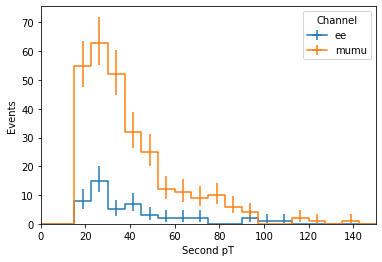

In [48]:
from coffea import hist

second_pt = hist.Hist("Events", 
                      hist.Cat(name='channel', label='Channel'), 
                      hist.Bin(name='pt2', label='Second pT', n_or_arr=20, lo=0, hi=150))

# For all event pts (:), get second index (1). Also, removed jagged structure to get flat array.
mumu_pt2 = mumu_channel.pt[:, 1].flatten()
ee_pt2 = ee_channel.pt[:, 1].flatten()

second_pt.fill(channel='mumu', pt2=mumu_pt2.flatten())
second_pt.fill(channel='ee', pt2=ee_pt2.flatten())

hist.plot1d(second_pt, overlay='channel')

<p>How about something with a little more topology? Let's plot "$\Delta \eta$ between the max-$\eta$ light jet and the max-pt bjet." In our case, a light jet will be defined as one that fails <code>loose_wp</code> and a bjet will be one that passes <code>loose_wp</code>.

In [18]:
mumu_jets = jets[dilepton_event & (tight_muons.counts == 2)]

light_jets = mumu_jets[mumu_jets.btagCSVV2 <= loose_wp]
bjets = mumu_jets[mumu_jets.btagCSVV2 > loose_wp]

We want to deal with comparisons between <code>light_jets</code> and <code>bjets</code>. To do so, let's introduce some combinatorics tools that Coffea features. For cross-array comparisons, <code>array1.cross(array2)</code> allows us to generate tuple pairs of elements in the form (array1 element, array2 element). We'll cross all of our bjets with the max-$\eta$ light jet, generating pairs of every bjet with one light jet from every event.

In [25]:
# argmax() returns the index of the maximum-valued element. Just another way to get max for an unordered array.
mumu_jetcross = bjets.cross(light_jets[light_jets.eta.argmax()])
print("bjets")
print(bjets)
print("\nmax-eta light jets")
print(light_jets[light_jets.eta.argmax()])
print("\ncrossed pairs")
print(mumu_jetcross)

bjets
[[<Jet 576> <Jet 580> <Jet 583>] [<Jet 1874>] [<Jet 1989> <Jet 1991> <Jet 1992> <Jet 1996>] ... [<Jet 794903>] [<Jet 802589>] [<Jet 804977> <Jet 804978>]]

max-eta light jets
[[<Jet 577>] [<Jet 1870>] [<Jet 1995>] ... [<Jet 794907>] [<Jet 802591>] [<Jet 804976>]]

crossed pairs
[[(<Jet 576>, <Jet 577>) (<Jet 580>, <Jet 577>) (<Jet 583>, <Jet 577>)] [(<Jet 1874>, <Jet 1870>)] [(<Jet 1989>, <Jet 1995>) (<Jet 1991>, <Jet 1995>) (<Jet 1992>, <Jet 1995>) (<Jet 1996>, <Jet 1995>)] ... [(<Jet 794903>, <Jet 794907>)] [(<Jet 802589>, <Jet 802591>)] [(<Jet 804977>, <Jet 804976>) (<Jet 804978>, <Jet 804976>)]]


Of course, <code>.cross()</code> will only return an actual pair if both events aren't empty. Otherwise, it'll return an empty subarray. We need to make sure there is more than one jet in each event; we can do this by checking that the <code>.counts</code> attribute is >= 1. Then, we need to find the pair in each event whose first entry (from bjets) has the highest pt. Of course, the <code>.cross()</code> is ordered by the first array, which was bjets, and that was ordered from highest to lowest pt, so the highest pt pair is the <b>first</b> pair.

In [34]:
mumu_jetpair = mumu_jetcross[mumu_jetcross.counts >= 1][:, 0]
mumu_jetpair

<Table [(<Jet 576>, <Jet 577>) (<Jet 1874>, <Jet 1870>) (<Jet 1989>, <Jet 1995>) ... (<Jet 794903>, <Jet 794907>) (<Jet 802589>, <Jet 802591>) (<Jet 804977>, <Jet 804976>)] at 0x7f99eedfa190>

And now all we have to do is find the difference in $\eta$ between the values of the pair. The respective pair-wise elements can be accessed by <code>.i0</code> and <code>.i1</code>. We take their difference (which is taking the difference of their Lorentz vector) and then ask for $\eta$.

/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


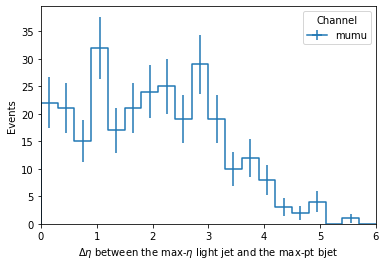

In [47]:
mumu_etadiff = hist.Hist("Events",
                      hist.Cat(name='channel', label='Channel'),
                      hist.Bin(name='etadiff', label=r'$\Delta \eta$ between the max-$\eta$ light jet and the max-pt bjet', n_or_arr=20, lo=0, hi=6))

# For all event pts (:), get second index (1). Also, removed jagged structure to get flat array.
mumu_fwdJet_leadbJet = np.abs((mumu_jetpair.i0 - mumu_jetpair.i1).eta)

mumu_etadiff.fill(channel='mumu', etadiff=mumu_fwdJet_leadbJet.flatten())
hist.plot1d(mumu_etadiff, overlay='channel')

<h2>Demo</h2>
<p>Alright, we've seen a lot of neat columnar tools, but it doesn't end there! Coffea also makes scale-out easy. All we have to do is bundle up our work in the <code>process.ProcessorABC</code> class, and we can feed in however many files we desire (which is, probably, more than 1) with ease. This class also features several executors which allow deployment on Dask, Spark, and Parsl, as well as your local machine. 

<p>To end this tutorial, we will diverge from this notebook a little bit, as I will demonstrate a run of the analysis on a Dask cluster; specifically, the analysis facility that Oksana Shadura <a href="https://indico.cern.ch/event/882824/timetable/#43-a-prototype-us-cms-analysis">gave a talk about</a> yesterday. If you want to look at, use as a reference, or play with my analysis later, you can run <a href="./analysis-local.ipynb">the analysis file that I've provided</a>, which uses the futures_executor to execute locally. You will, however, need a CMS certificate to be able to access its datasets. Failure to do so will result in the oh-so-familiar <code>OSError: [FATAL] Invalid address</code>.

<h2>Acknowledgements</h2>
<p>These projects are supported by National Science Foundation grants ACI-1450323 (through DIANA-HEP), OAC-1836650 (through IRIS-HEP), and PHY-1624356 (through U.S. CMS).</p>